In [1]:
from dataset import PretrainingDataset,SegmentationDataset,LungCTFullImageDataset,LungRadiomicsInterobserverDataset,LungRadiomicsDataset,VolumeLungRadiomicsInterobserverDataset,VolumeLungRadiomicsDataset
from model import ThreeDimensionalTransformer,load_model,VolumeTransformer6,MyAttention,MiniTransformer6,ThreeDimensionalUNet,MiniTransformer4,MiniTransformer5,Transformer4
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
#from pretrain import make_data
import pydicom
from train_volume import make_data,make_model,train
from metrics import DSC,DSCManager,weightDSC
from loss_function import DiceLoss,DSLManager,BCE_with_DiceLoss


In [2]:
model=load_model("/home/nfs/snakagawa/Strage/CancerSegmentation/models/train/2022-02-09-20-37-50.pt",torch.device("cpu"),"VolumeTransformer6",pretrain=False)
#model=load_model("/home/nfs/snakagawa/Strage/CancerSegmentation/models/train/2022-02-06-21-30-41.pt",torch.device("cpu"),"Transformer2",pretrain=False)
#model=load_model("/home/nfs/snakagawa/Strage/CancerSegmentation/models/train/2022-01-25-15-33-44.pt",torch.device("cpu"),"ThreeDimensionalUNet")
#model=VolumeTransformer6()

In [3]:
dataset=VolumeLungRadiomicsDataset(key="GTV-1")

423it [00:00, 511.66it/s]


In [4]:
loader=DataLoader(dataset,batch_size=1)
#loader=DataLoader(patch_provider,batch_size=1)
iterator=iter(loader)

In [5]:
image,label =next(iterator)


In [6]:
#image=image.to(torch.device("cuda:0"))
#image.requires_grad=True
predict=model(image)
#predict=model(torch.flip(image,[2])).cpu().detach()
image=image


In [16]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
loss=BCE_with_DiceLoss(predict,label)
loss.backward()
optimizer.step()

In [9]:
image,label =next(iterator)
predict2=model(image).cpu().detach()
#predict=model(torch.flip(image,[2])).cpu().detach()
image=image.cpu().detach()


In [7]:
predict=predict.detach()
image=image.detach()

In [10]:
DSC(predict,predict2)

tensor(1.0000)

In [13]:
DSC(predict,label)

tensor(0.2078)

In [74]:
for depth in range(label.size()[2]):
    if label[:,0,depth].max()>0.5:
        print(depth)

65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


In [35]:
binpre=torch.where(predict>0.5,1,0)

In [10]:
emb=model.norm1(model.patch_embed(image))
#emb=model.patch_embed(image)

In [11]:
emb.max()

tensor(5.9735, grad_fn=<MaxBackward1>)

In [12]:
x=model.block1.attn(emb)

In [14]:
x.max()

tensor(16006.7754, grad_fn=<MaxBackward1>)

In [16]:
emb2=torch.reshape(emb,(1,10,16,16,32,32,32))
#emb2=torch.reshape(emb,(1,20,32,32,16,16,16))
emb3=torch.reshape(emb2.permute(0,1,4,2,5,3,6),(1,1,320,512,512))

In [14]:
x1=model.block1(emb)

In [42]:
x1.shape

torch.Size([1, 20480, 4096])

In [19]:
x1.size()

torch.Size([1, 2560, 128])

In [18]:
#x2=torch.reshape(x1,(1,20,32,32,16,16,16))
x2=torch.reshape(x1,(1,10,16,16,32,32,32))
x3=torch.reshape(x2.permute(0,1,4,2,5,3,6),(1,1,320,512,512))

RuntimeError: shape '[1, 10, 16, 16, 32, 32, 32]' is invalid for input of size 327680

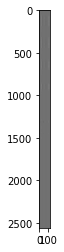

In [22]:
plt.imshow(x1[0].detach(),cmap="gray")

In [23]:
x1[0][0]

tensor([ 0.2735, -0.0245,  0.5199, -0.4072, -0.0665, -0.6826, -0.1527, -0.3366,
         0.5657,  0.2665, -0.6541, -0.2698, -0.1993,  0.6322,  0.7135,  0.0171,
        -0.7181, -0.6910, -0.3986, -0.0810,  0.0231,  0.4001, -0.3175,  0.2234,
         0.6207,  0.0808,  0.1200,  0.1475,  0.0267,  0.3240,  0.4096,  0.3162,
         0.6889, -0.5447,  0.1301, -0.6447,  0.0680,  0.0346,  0.0505,  0.0366,
        -0.2910, -0.5882,  0.0827,  0.4136, -0.4456,  0.2660, -0.4599, -0.3094,
        -0.2358, -0.3046,  0.6504,  0.0474, -0.1499, -0.1849,  0.2968,  0.3232,
        -0.0416,  0.3901, -0.5044, -0.0955,  0.1929, -0.1177,  0.1337,  0.1362,
        -0.0899, -0.0787,  0.0108, -0.4105,  0.1038,  0.6600, -0.1642, -0.1288,
        -0.3262,  0.1328,  0.7026, -0.9396, -0.3890, -0.1344, -0.1673, -0.1920,
        -0.1059,  0.9597, -0.7273, -0.4700, -0.1445, -0.1764,  0.0757,  0.6480,
        -0.5388, -0.5035,  0.0853,  0.4935, -0.6448, -0.0984,  0.2425,  0.0123,
         0.2463, -0.3587,  0.7537,  0.09

In [15]:
emb.max()

tensor(4.4370, grad_fn=<MaxBackward1>)

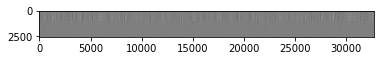

In [10]:
#plt.imshow(torch.cat([x]*1000,dim=2)[0].detach(),cmap="gray")
plt.imshow(emb[0].detach(),cmap="gray")

In [25]:
x1=model.block1(emb)
#x2=nn.LayerNorm([2560,128])(model.block2(x1))
x3=model.block3(x1)+x1
#x4=nn.LayerNorm([2560,128])(model.block4(x3)+x1)
x5=model.block5(x3)

In [26]:
print(x1.max(),x3.max(),x5.max())

tensor(16.1129, grad_fn=<MaxBackward1>) tensor(1409.8834, grad_fn=<MaxBackward1>) tensor(4.2025, grad_fn=<MaxBackward1>)


In [19]:
emb.size()

torch.Size([1, 2560, 32768])

In [43]:
#qkv=model.block1.attn.qkv(emb).reshape(1, 2560, 3, model.block1.attn.num_heads, model.block1.attn.out_dim // model.block1.attn.num_heads).permute(2, 0, 3, 1, 4)
#qkv=model.block1.attn.qkv(emb).reshape(1, 20480, 3, model.block1.attn.num_heads,  4096// model.block1.attn.num_heads).permute(2, 0, 3, 1, 4)
#qkv=model.block2.attn.qkv(x1).reshape(1, 2560, 3, model.block2.attn.num_heads,128// model.block2.attn.num_heads).permute(2, 0, 3, 1, 4)
qkv=model.block3.attn.qkv(x1).reshape(1, 2560, 3, model.block3.attn.num_heads,128// model.block3.attn.num_heads).permute(2, 0, 3, 1, 4)
#qkv=model.block4.attn.qkv(x3).reshape(1, 2560, 3, model.block4.attn.num_heads,128// model.block4.attn.num_heads).permute(2, 0, 3, 1, 4)
#qkv=model.block5.attn.qkv(x3).reshape(1, 2560, 3, model.block5.attn.num_heads,128).permute(2, 0, 3, 1, 4)

In [44]:
qkv.min()

tensor(-78.7591, grad_fn=<MinBackward1>)

In [45]:
q,k,v=qkv[0], qkv[1], qkv[2] 

In [30]:
q.mean()

tensor(0.0090, grad_fn=<MeanBackward0>)

In [53]:
#attn =model.block1.attn.norm(q @ k.transpose(-2, -1)).softmax(dim=-1)
attn =(q @ k.transpose(-2, -1)*model.block3.attn.scale).softmax(dim=-1)

In [48]:
#model.block1.attn.norm((q @ k.transpose(-2, -1))).max()
(q @ k.transpose(-2, -1)).max()

tensor(53056.3750, grad_fn=<MaxBackward1>)

In [51]:
model.block3.attn.scale

0.0078125

In [58]:
attn[0,0].max()

tensor(5.3783e-39, grad_fn=<MinBackward1>)

In [63]:
attn.size()

torch.Size([1, 2, 20480, 20480])

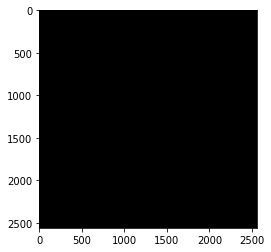

In [64]:
plt.imshow(attn[0,5].detach(),cmap="gray")

In [127]:
attn

tensor([[[[4.2088e-04, 4.1757e-04, 4.1601e-04,  ..., 4.2126e-04,
           4.2110e-04, 4.2126e-04],
          [4.2066e-04, 4.1734e-04, 4.1581e-04,  ..., 4.2103e-04,
           4.2088e-04, 4.2103e-04],
          [4.2054e-04, 4.1726e-04, 4.1573e-04,  ..., 4.2091e-04,
           4.2076e-04, 4.2091e-04],
          ...,
          [4.2090e-04, 4.1760e-04, 4.1603e-04,  ..., 4.2127e-04,
           4.2112e-04, 4.2127e-04],
          [4.2089e-04, 4.1759e-04, 4.1602e-04,  ..., 4.2126e-04,
           4.2111e-04, 4.2126e-04],
          [4.2090e-04, 4.1760e-04, 4.1603e-04,  ..., 4.2128e-04,
           4.2112e-04, 4.2128e-04]],

         [[7.5624e-05, 8.7029e-05, 8.7439e-05,  ..., 7.4349e-05,
           7.4455e-05, 7.4301e-05],
          [7.9054e-05, 9.0749e-05, 9.1166e-05,  ..., 7.7745e-05,
           7.7854e-05, 7.7696e-05],
          [7.8631e-05, 9.0287e-05, 9.0705e-05,  ..., 7.7327e-05,
           7.7435e-05, 7.7278e-05],
          ...,
          [7.5156e-05, 8.6520e-05, 8.6929e-05,  ..., 7.3886

In [51]:
attn[0,0,:,6500].sum()

tensor(8.3620, grad_fn=<SumBackward0>)

In [26]:
qkv.max()

tensor(16731.4668, grad_fn=<MaxBackward1>)

In [69]:
for depth in range(2560):
    if attn[0,0,:,depth].sum()>0:
        print(depth)

2480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6391, grad_fn=<MaxBackward1>)
tensor(0.5288)


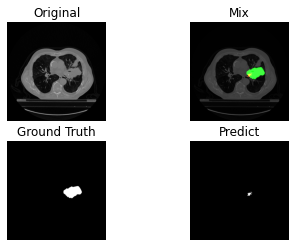

In [7]:
depth=72
fig,axs=plt.subplots(2,2)

impose=torch.cat([image,image,image],dim=1)
impose[:,0]+=(predict[:,0]>=0.5)
impose[:,1]+=label[:,0]
#impose[1,8:16,8:16]-=(label[0,0,depth]*0.1)
#impose[2,8:16,8:16]-=(label[0,0,depth]*0.1)
#impose=(impose-impose.min())/(impose.max()-impose.min())

print(predict[:,0,depth].max())
print(image[:,0,depth].max())
axs[0,0].imshow(image[0,0,depth],cmap="gray")
#axs[0,0].imshow(emb[0].detach().numpy(),cmap="gray")
axs[0,0].set_title("Original")
#axs[1].imshow(predict[0,0,depth]>0.5,cmap="gray")
axs[1,0].imshow(label[0,0,depth],cmap="gray")
axs[1,0].set_title("Ground Truth")
#axs[1,1].imshow(emb3.detach()[0,0,depth],cmap="gray")
axs[1,1].imshow(predict[0,0,depth,]>0.5,cmap="gray")
axs[1,1].set_title("Predict")
axs[0,1].imshow(impose[0,:,depth].permute(1,2,0))
axs[0,1].set_title("Mix")
fig.show()
for ax in axs.flatten():
    ax.axis("off")
fig.savefig("inout14.png")

In [45]:
DSC(predict,label)

tensor(0.2502)

In [ ]:
depth=65
fig,axs=plt.subplots(1,3)
axs[0].imshow(image[depth],cmap="gray")
#axs[1].imshow(predict[0,0,depth]>0.5,cmap="gray")
axs[2].imshow(label[depth],cmap="gray")
fig.show()

In [ ]:
BCE_with_DiceLoss(predict,labels)

In [ ]:
temp=torch.zeros_like(label[:,0])
temp=torch.stack([temp,1-temp],dim=1)
print(weightDSC(temp,labels))
print(DSC(temp,labels))
print(BCE_with_DiceLoss(temp,labels))


In [ ]:
i=0
cancers=[]
for image,labels in loader:    
    max=list(labels.values())[0][0,0].max()
    if max>0:
        cancers.append((image,labels))
        #print(i)
        i+=1
print(i)


In [ ]:
image=patch_provider.cube
label=list(patch_provider.labels.values())[0]
for i in range(image.size()[0]):
    if label[i].max()!=0:
        print(i)

In [ ]:
depth=33
fig,axs=plt.subplots(1,2)
axs[0].imshow(image[depth],cmap="gray")
axs[1].imshow(label[depth],cmap="gray")
fig.show()

In [ ]:
cancer_id=50
for depth in range(8):
    label=list(cancers[cancer_id][1].values())[0]
    if label[0,0,depth].max()!=0:
        print(depth)

In [ ]:
depth=3
fig,axs=plt.subplots(1,2)
axs[0].imshow(cancers[cancer_id][0][0,0,depth+8],cmap="gray")
axs[1].imshow(list(cancers[cancer_id][1].values())[0][0,0,depth],cmap="gray")
fig.show()
axs[0].set_title("input")
axs[1].set_title("label")
axs[0].tick_params(labelbottom=False,
               labelleft=False,
               labelright=False,
               labeltop=False)
axs[1].tick_params(labelbottom=False,
               labelleft=False,
               labelright=False,
               labeltop=False)

In [ ]:
len(axs)

In [ ]:
patch_provider.cube.size()

In [ ]:
label=list(labels.values())[0]

In [ ]:
for i in range(8):
    if label[0,0,i].max()!=0:
        print(i)

In [ ]:
plt.imshow(image[0,0,13],cmap ="gray")

In [ ]:
plt.imshow(label[0,0,4,:,:],cmap="gray")


In [ ]:
plt.imshow(labels["label"][0,0,0,:,:],cmap="gray")


In [ ]:
pre=model(image)


In [ ]:
plt.imshow(pre.detach().numpy()[0,0,0,:,:],cmap="gray")

In [ ]:
DiceLoss(pre,labels)

In [ ]:
traindata,valdata=make_data()
model=make_model()

In [ ]:
BATCH_SIZE=5
patch_provider=traindata[0]
trainloader=DataLoader(patch_provider,batch_size=BATCH_SIZE)
dscmanager=DSCManager()
for image,labels in trainloader:
    pre=torch.zeros_like(list(labels.values())[0])
    dscmanager.register(pre,labels)
dsc=dscmanager.calculate()
print(dsc)

In [ ]:
for image,label in trainloader:
    if label['GTV-1auto-3'][4][0].max()!=0:
        print("end")
        break 
    

In [ ]:
image[:,:,16:32,16:32,16:32].size()

In [ ]:
label['GTV-1auto-3'][4][0][10]

In [ ]:
label.keys()

In [ ]:
plt.imshow(label['GTV-1vis-'][4][0][10],cmap="gray")

In [ ]:
plt.imshow(label['GTV-1auto-3'][4][0][10],cmap="gray")

In [ ]:
image.size()

In [ ]:
pre=model(image.to(torch.device("cuda:0")))

In [ ]:
pre.size()

In [ ]:
DSC(pre,[image[:,:,16:32,16:32,16:32].to(torch.device("cuda:0"))])

In [ ]:
#DSC(pre.cpu(),label)
DiceLoss(pre.cpu(),label)

In [ ]:
DSC(pre.cpu(),label)

In [ ]:
plt.imshow(pre[4][0][10].cpu().detach().numpy(),cmap="gray")

In [ ]:
plt.imshow(image[4][0][26],cmap="gray")

In [ ]:
plt.imshow(image[4][0][26][16:32,16:32],cmap="gray")

In [ ]:
dataset=LungRadiomicsInterobserverDataset()

In [ ]:
#dataloader=DataLoader(dataset,batch_size=1,collate_fn=collate_fn)
dataloader=DataLoader(dataset[0],batch_size=1)

In [ ]:
next(iter(dataloader))[0].size()

In [ ]:
with pydicom.dcmread("/home/s0ran/Strage/CancerSegmentation/dataset/manifest-1598890146597/NSCLC-Radiomics-Interobserver1/interobs05/02-18-2019-NA-CT-90318/1.000000-Segmentation-94745/1-1.dcm") as dc:
    print(dir(dc))
    print(dc.SeriesDescription)

In [ ]:
train,test=make_data()

In [ ]:
for i in range(2000):
    print(i,train[0][1][i][0][0].max())

In [ ]:
dataset=LungCTFullImageDataset()
patch_provider=train[0][1]
print(patch_provider[0][0][0].size())
print(patch_provider[0][0][0].argmax())
plt.imshow(patch_provider[7][0][0][20],cmap="gray")

In [ ]:
image_id=0
patch_id=50
dataset=train[image_id][1]
depth_id=0
fig,axs=plt.subplots(1,2)
axs[0].imshow(dataset[patch_id][0][0][depth_id+16],cmap="gray",vmin=0,vmax=1)
axs[0].set_title("input")
axs[1].imshow(dataset[patch_id][1][0][depth_id],cmap="gray",vmin=0,vmax=1)
axs[1].set_title("ground truth")
print(dataset[patch_id][0][0][depth_id+16].min())
print(dataset[patch_id][0][0][depth_id+16].max())
print(dataset[patch_id][1][0][depth_id].min())
print(dataset[patch_id][1][0][depth_id].max())


for ax in axs:
    pass
    ax.axis("off")

fig.savefig("../images/pretrainingexample2")

In [ ]:
for pathc_id in range(len(dataset)):
    print(dataset[patch_id][0][0][depth_id].sum())


In [ ]:
dataset[0][1].shape

In [ ]:
dataset[0][1].sum(dim=1).sum(dim=1).size()


In [ ]:
image_id=0
depth_id=45

fig,axs=plt.subplots(1,2)
axs[0].imshow(dataset[image_id][0][depth_id],cmap="gray")
axs[0].set_title("raw image")
axs[1].imshow(dataset[image_id][1][depth_id*10],cmap="gray")
axs[1].set_title("segmentation")
for ax in axs:
    ax.axis("off")
fig.savefig("../images/tumorexample.png")

In [ ]:
image_id=0
#depth_id=45
start=446
end=458
sep=4

fig,axs=plt.subplots((end-start)//sep,sep)
for i,v in enumerate(range(446,458)):
    axs[i//sep][i%sep].imshow(dataset[image_id][1][v],cmap="gray")
    axs[i//sep][i%sep].set_title(v)
    axs[i//sep][i%sep].axis("off")
fig.savefig("../images/surrounding.png")

In [ ]:
data,label=pretraining_data[0][1][900]
label.size()
plt.imshow(label[0],cmap="gray")

In [ ]:
metadata.columns
features=['Series UID', 
       #'Collection',
       # '3rd Party Analysis',
       'Data Description URI', 'Subject ID', 'Study UID', 'Study Description',
       'Study Date', 'Series Description', 'Manufacturer', 'Modality',
       'SOP Class Name', 
       #'SOP Class UID', 
       'Number of Images', 'File Size',
       'File Location', 'Download Timestamp']

In [ ]:
metadata["SOP Class Name"].unique()

In [ ]:
metadata[metadata["Subject ID"]=="Lung_Dx-A0166"]

In [ ]:
len(metadata[metadata["Modality"]=="PT"])

In [ ]:
metadata[metadata["Study UID"]=="1.3.6.1.4.1.14519.5.2.1.6655.2359.104855313699639828167809534834"]